In [1]:
import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.functional import F
import time
import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
df = pd.read_csv('data/train_gened.csv')

In [44]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"DataFrame占用大小 {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"DataFrame优化后占用大小: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"优化了 {decrease:.2f}%")

    return df

# 数据载入

In [5]:
x_cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'target']]
y_cols = ["target"]

In [6]:
def normalize_features(x, means, stds):
    return (x - means) / (stds + 1e-8)

def get_xy(df, x_cols, y_cols, means, stds):
    x = df[x_cols]
    x = normalize_features(x, means, stds)
    y = df[y_cols]
    return x.values, y.values

def get_dataloaders(df, x_cols, y_cols, batch_size=512):
    # 划分训练集和测试集
    train_size = int(len(df) * 0.8)
    valid_size = len(df) - train_size
    train_df, valid_df = random_split(df, [train_size, valid_size])

    # 计算训练集的均值和标准差用于标准化
    means = train_df.dataset.loc[train_df.indices][x_cols].mean()
    stds = train_df.dataset.loc[train_df.indices][x_cols].std()

    # 获取标准化后的训练集和测试集
    x_train, y_train = get_xy(train_df.dataset.loc[train_df.indices], x_cols, y_cols, means, stds)
    x_valid, y_valid = get_xy(valid_df.dataset.loc[valid_df.indices], x_cols, y_cols, means, stds)

    # 转换为 PyTorch 张量
    train_dataset = TensorDataset(torch.Tensor(x_train).to(device), torch.Tensor(y_train).to(device))
    test_dataset = TensorDataset(torch.Tensor(x_valid).to(device), torch.Tensor(y_valid).to(device))

    # 创建 DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=min(batch_size * 4, len(test_dataset)), drop_last=True)

    return train_dataloader, test_dataloader


In [7]:
train_dataloader, test_dataloader = get_dataloaders(df, x_cols, y_cols)

In [88]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([512, 81]) torch.Size([512, 1])


# 模型训练函数

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, shortcut=0):
    size = len(dataloader.dataset)
    model.train()
    num_batches = len(dataloader)

    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X)
        
        loss = loss_fn(pred, y)
        train_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if pred.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break
        
        if shortcut > 0 and batch == shortcut:
            return train_loss.detach().cpu().numpy() / shortcut
    return train_loss.detach().cpu().numpy() / num_batches


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
      
            
            pred = model(X)
            test_loss += loss_fn(pred, y).detach().cpu().numpy()
    
        scheduler.step(test_loss)
    return test_loss / num_batches
        
def predict(X, model):
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy().flatten()

In [9]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# 构建模型

In [10]:
def init_rnn(rnn, init_type='xavier'):
    for name, param in rnn.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0.0)
        elif 'weight' in name:
            if init_type == 'xavier':
                nn.init.xavier_normal_(param)
            else:
                nn.init.normal_(param)

lstm

In [65]:
class LSTM(nn.Module):
    def __init__(self, input_size=81, hidden_layer_size=50, output_size=1, num_layers=5):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.batch_size = 1   

        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=20, kernel_size=2)
        self.lstm = nn.LSTM(20, hidden_layer_size, num_layers, dropout=0.2)

        self.linear_adjust = nn.Linear(hidden_layer_size, hidden_layer_size) 
        self.fc1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_size, output_size)

        self.dropout = nn.Dropout(0.2)

        self.risidual = nn.Linear(hidden_layer_size, 1)

        init_rnn(self.lstm, 'xavier')

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)
        input_seq = self.conv1d(input_seq)
        input_seq = input_seq.permute(0, 2, 1)
        lstm_out, (hidden, _) = self.lstm(input_seq.reshape(len(input_seq[0]), 1, 20))
        
        adjusted_lstm_out = self.linear_adjust(lstm_out[-1])

        out = self.fc1(adjusted_lstm_out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)

        out = torch.tanh(out)

        return out[-1]


原始AT-LSTM

In [66]:
class LSTMwithAttention_1(nn.Module):
    def __init__(self, input_size=81, hidden_layer_size=50, output_size=1, num_layers=5):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.batch_size = 1   

        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=35, kernel_size=2)
        self.lstm = nn.LSTM(20, hidden_layer_size, num_layers, dropout=0.2)

        # 使用ReLU激活函数
        self.fc1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_size, output_size)

        self.dropout = nn.Dropout(0.5)
        self.attn_weights = None

        # 初始化LSTM层的权重
        init_rnn(self.lstm, type='xavier')



    def attention_net(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.view(-1, self.hidden_layer_size, self.num_layers)
        self.attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)

        soft_attn_weights = F.tanh(self.attn_weights)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights).squeeze(2)
        return context 

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)
        input_seq = self.conv1d(input_seq)
        input_seq = input_seq.permute(0, 2, 1)
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq[0]), 1, 20))

        attn_output = self.attention_net(lstm_out, self.hidden_cell[0])
        
        out = self.fc1(attn_output.view(-1, self.hidden_layer_size))
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        
        return out[-1]

LSTM与输出残差连接

In [67]:
class LSTMwithAttention_2(nn.Module):
    def __init__(self, input_size=81, hidden_layer_size=50, output_size=1, num_layers=5):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.batch_size = 1   

        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=20, kernel_size=2)
        self.lstm = nn.LSTM(20, hidden_layer_size, num_layers, dropout=0.2)

        self.linear_adjust = nn.Linear(hidden_layer_size, hidden_layer_size) # 调整维度的线性层

        self.fc1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_size, output_size)

        self.dropout = nn.Dropout(0.5)
        self.attn_weights = None
        self.risidual = nn.Linear(hidden_layer_size, 1)

        init_rnn(self.lstm, 'xavier')


    def attention_net(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.view(-1, self.hidden_layer_size, self.num_layers)
        self.attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)

        soft_attn_weights = torch.tanh(self.attn_weights)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights).squeeze(2)
        return context 

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)
        input_seq = self.conv1d(input_seq)
        input_seq = input_seq.permute(0, 2, 1)
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq[0]), 1, 20))

        # 调整LSTM输出的维度
        adjusted_lstm_out = self.linear_adjust(lstm_out[-1])
        # print(f'adjusted_lstm_out.shape: {adjusted_lstm_out.shape}')

        attn_output = self.attention_net(lstm_out, self.hidden_cell[0])
        # print(f'attn_output.shape: {attn_output.shape}')
        
        # 线性层处理
        out = self.fc1(attn_output.view(-1, self.hidden_layer_size))
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)

        
        # 添加残差连接
        out = self.risidual(adjusted_lstm_out) + out
        # print(f'2out.shape: {out.shape}')
        out = torch.tanh(out)

        return out[-1]




使用加性注意力

In [112]:
class LSTMwithAttention_3(nn.Module):
    def __init__(self, input_size=81, hidden_layer_size=50, output_size=1, num_layers=5):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.batch_size = 1   

        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=20, kernel_size=2)
        self.lstm = nn.LSTM(20, hidden_layer_size, num_layers, dropout=0.2)

        self.linear_adjust = nn.Linear(hidden_layer_size, hidden_layer_size) 
        self.fc1 = nn.Linear(hidden_layer_size, 206)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(206, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 512)

        self.dropout = nn.Dropout(0.2)

        # 注意力机制的组件
        self.attention_linear = nn.Linear(2 * hidden_layer_size, hidden_layer_size)
        self.attention_vector = nn.Parameter(torch.randn(hidden_layer_size))

        self.risidual = nn.Linear(hidden_layer_size, 1)

        init_rnn(self.lstm, 'xavier')
        
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.repeat(lstm_output.size(0), 1, 1).transpose(0, 1)
        lstm_output = lstm_output.transpose(0, 1)
        attn_input = torch.cat((lstm_output, hidden), 2)
        energy = torch.tanh(self.attention_linear(attn_input))
        attention = torch.matmul(energy, self.attention_vector)
        attention_weights = F.softmax(attention, dim=1)

        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), attention_weights.unsqueeze(2)).squeeze(2)
        return new_hidden_state

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)
        # print(f'input_seq.shape: {input_seq.shape}')
        input_seq = self.conv1d(input_seq)
        # print(f'after conv1d, input_seq.shape: {input_seq.shape}')
        input_seq = input_seq.permute(0, 2, 1)
        # print(f'after permute, input_seq.shape: {input_seq.shape}')
        lstm_out, (hidden, _) = self.lstm(input_seq.reshape(len(input_seq[0]), 1, 20))
        # print(f'lstm_out.shape: {lstm_out.shape}')
        adjusted_lstm_out = self.linear_adjust(lstm_out[-1])
        
        attn_output = self.attention_net(lstm_out, hidden[-1])
        # print(f'attn_out.shape: {attn_output.shape}')

        out = self.fc1(attn_output.view(-1, self.hidden_layer_size))
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        # print(f'out.shape: {out.shape}')
        out = self.risidual(adjusted_lstm_out) + out
        # print(f'2out.shape: {out.shape}')
        out = torch.tanh(out).transpose(0, 1)
        # print(f'3out.shape: {out.shape}')

        return out



In [113]:
model = LSTMwithAttention_3().to(device)

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

loss_fn = nn.L1Loss()

In [115]:
history = pd.DataFrame([], columns=["epoch","train_loss","test_loss","lr"])

t1 = time.time()

for epoch in range(20):
    
    print(f"Epoch {epoch+1:>3d}",end=" ")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, shortcut=0)
    print(f"Train: {train_loss:>5f}", end=" ")
    test_loss = test_loop(test_dataloader, model, loss_fn)
    print(f"| Test: {test_loss:>5f}")

    if early_stopper.early_stop(test_loss, model) or time.time() - t1 > 60*60*8:  
        model = early_stopper.get_best_model()
        break

    history.loc[len(history),:] = [epoch+1, train_loss, test_loss, optimizer.param_groups[0]['lr']]


Epoch   1 Train: 6.409966 

c:\Users\zhiwei\anaconda3\envs\torchenv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([2048, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (512) must match the size of tensor b (2048) at non-singleton dimension 0

In [73]:
history

,epoch,train_loss,test_loss,lr
0,1,6.409797,6.398921,0.0008
1,2,6.409755,6.398902,0.0008
2,3,6.40979,6.398913,0.0008
3,4,6.409748,6.398913,0.0008
4,5,6.409716,6.398977,0.0008
5,6,6.409779,6.3989,0.0008
6,7,6.409784,6.398911,0.0008
7,8,6.409763,6.3989,0.0008
8,9,6.409755,6.398926,0.0008


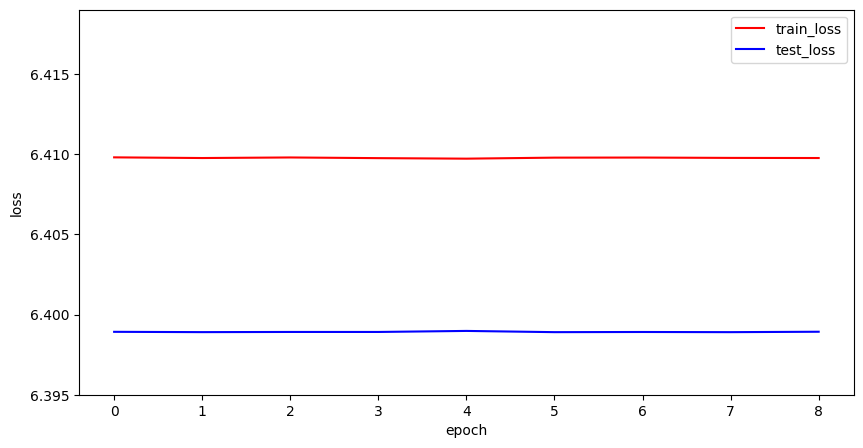

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='train_loss',color='red')
plt.plot(history['test_loss'], label='test_loss',color='blue')

plt.ylim(6.395, 6.419)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
history.to_csv("history_2.csv", index=False)

In [ ]:
# predict
mae = test_loop(test_dataloader, model, loss_fn)

c:\Users\zhiwei\anaconda3\envs\torchenv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([2048, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [ ]:
mae

6.416089995733213

In [ ]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 2797.34 MB
Memory usage after optimization is: 914.13 MB
Decreased by 67.32%
